In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torchvision import transforms as trn
from torch.autograd import Variable as V
import pandas as pd
import dlib
import cv2
device = torch.device('cuda')

In [ ]:
def preprocess(image_fname):
    center_crop = trn.Compose([
        trn.Resize((256, 256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_input = Image.open(image_fname)
    img_output = V(center_crop(img_input).unsqueeze(0))
    if torch.cuda.is_available():
      img_output = img_output.cuda()
    return img_output

In [ ]:
def predict(img_path):
    img=preprocess(img_path)
    outputs = model(img)
    max = torch.softmax(outputs, 1)
    if max[0][0] > 0.5:
      masked = 'not masked'
      label = 0
      prob = max[0][0]
    else:
      masked = 'masked'
      label = 1
      prob = max[0][1]
    return label, prob, masked

In [ ]:
def preprocess_multi(image):
    center_crop = trn.Compose([
        trn.Resize((256, 256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_input = Image.fromarray(image)
    img_output = V(center_crop(img_input).unsqueeze(0))
    if torch.cuda.is_available():
      img_output = img_output.cuda()
    return img_output

In [ ]:
def predict_multi(img_path):
    img=preprocess_multi(img_path)
    outputs = model(img)
    max = torch.softmax(outputs, 1)
    if max[0][0] > 0.5:
      masked = 'not masked'
      label = 0
      prob = max[0][0]
    else:
      masked = 'masked'
      label = 1
      prob = max[0][1]
    return label, prob, masked

In [ ]:
def test(filename):
  data_path = 'gdrive/My Drive/dataset/'+filename+'/'
  # data_path = 'gdrive/My Drive/CV-FinalProject/dataset/test_real/'+filename+'/'
  test = pd.read_csv((data_path + filename+'.csv'), index_col=0)
  cor = 0
  err = 0
  for i in range(test.shape[0]):
    filename = test.iloc[i, 0]
    label = test.iloc[i, 1]
    rlt, prob, masked = predict((data_path + filename))
    print('{} predicted as {} with probability {:.3f}'.format(filename, masked, prob))
    if rlt == label:
      cor += 1.0
    else:
      err += 1.0
    AP = cor / (cor + err)
    print('Cumulative accuracy: {:.3f}'.format(AP))

**Load the model and replace the output layer with a 2 class layer. Then load the save weights from training. Set to evaluate mode and send to cuda if available.**

In [ ]:
model = torchvision.models.googlenet(pretrained = True)
model.fc = nn.Linear(in_features=1024, out_features=2, bias=True)
model.load_state_dict(torch.load('gdrive/My Drive/dataset/GoogLenet_masknet.pth'))
# model.load_state_dict(torch.load('gdrive/My Drive/CV-FinalProject/step2_training/GoogLenet_masknet.pth'))
model.eval()
#send to GPU
if torch.cuda.is_available():
  model.cuda()

# Test on one image with multiple faces

In [ ]:
def test_image(img):

  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
  detector = dlib.get_frontal_face_detector()

  dets = detector(img, 1)
  print(dets)
  for i, d in enumerate(dets):
    print('- %d：Left %d Top %d Right %d Bottom %d' % (i, d.left(), d.top(), d.right(), d.bottom()))
    img = cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), (0,0,255), 5)
    face = img[d.top():d.bottom(),d.left():d.right()]
    rlt, prob, masked = predict_multi(face)
    img = cv2.putText(img, masked, (d.left(), d.top()), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)

  return img

In [ ]:
path = 'test.png'
img = cv2.imread(path)

None


rectangles[[(772, 223) (880, 331)], [(304, 150) (459, 305)], [(640, 254) (769, 383)]]
- 0：Left 772 Top 223 Right 880 Bottom 331


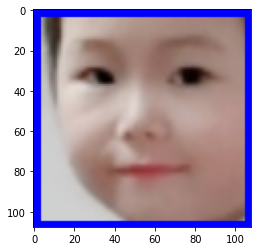

not masked
- 1：Left 304 Top 150 Right 459 Bottom 305


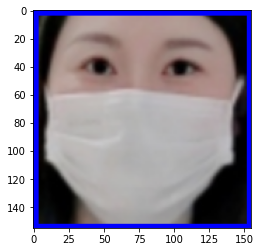

masked
- 2：Left 640 Top 254 Right 769 Bottom 383


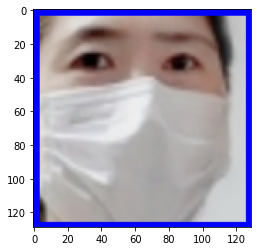

masked


True

In [ ]:
import matplotlib.pyplot as plt
path = 'test.png'
# path = 'gdrive/My Drive/CV-FinalProject/step3_detection/test.png'
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
detector = dlib.get_frontal_face_detector()

dets = detector(img, 1)
print(dets)
for i, d in enumerate(dets):
  print('- %d：Left %d Top %d Right %d Bottom %d' % (i, d.left(), d.top(), d.right(), d.bottom()))
  img = cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), (0,0,255), 5)
  face = img[d.top():d.bottom(),d.left():d.right()]
  plt.imshow(face)
  plt.show()
  rlt, prob, masked = predict_multi(face)
  print(masked)
  img = cv2.putText(img, masked, (d.left(), d.top()), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
# cv2.imwrite('gdrive/My Drive/CV-FinalProject/step3_detection/test_GoogLeNet.png',cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

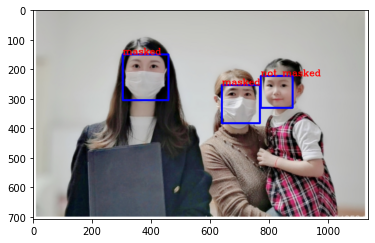

In [ ]:
plt.imshow(img)

# Test on video



In [ ]:
from google.colab.patches import cv2_imshow
from time import sleep
from IPython.display import clear_output
video = cv2.VideoCapture('test_video.mp4')
for i in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
  ret, frame = video.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame_detected = test_image(frame)
  clear_output(wait=True)
  cv2_imshow(frame_detected)
  sleep(0.4)

In [ ]:
video = cv2.VideoCapture('gdrive/My Drive/CV-FinalProject/step3_detection/test_video.mp4')
frame_width = int(video.get(3)) 
frame_height = int(video.get(4)) 
size = (frame_width, frame_height)
result = cv2.VideoWriter('gdrive/My Drive/CV-FinalProject/step3_detection/test_video_GoogLeNet.mp4',  
                         cv2.VideoWriter_fourcc(*'MP4V'), 
                         30, size) 

while(True): 
  ret, frame = video.read() 
  if ret == True:  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_detected = test_image(frame)
    result.write(frame_detected) 
  else: 
    break
  
video.release() 
result.release()

rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(414, 192) (637, 415)]]
- 0：Left 414 Top 192 Right 637 Bottom 415
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 613 Bottom 407
rectangles[[(428, 222) (613, 407)]]
- 0：Left 428 Top 222 Right 6